In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]    
    return t

def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)

In [3]:
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10, lr=1e-3):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
    def call(self, x):
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y, is_gibbs = False, is_hmc = False):
        
        # get current state
        if is_hmc:
            h_current = tf.split(h, self.hidden_layer_sizes, axis = 1)
        else:    
            h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h]
        h_current = convert2_zero_one(h_current)
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(zip(h_current, h_previous, self.fc_layers)):
            
            logits = layer(pv)
            ce = tf.nn.sigmoid_cross_entropy_with_logits(labels = cv, logits = logits)
            if not is_gibbs:
                ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def gibbs_new_state(self, x, h, y):
        
        '''
            generate a new state for the network node by node in Gibbs setting.
        '''
        
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        
        in_layers = self.fc_layers
        out_layers = self.fc_layers[1:] + [self.output_layer]
        
        prev_vals = [x] + h_current[:-1]
        curr_vals = h_current
        next_vals = h_current[1:] + [y]
        
        for i, (in_layer, out_layer, pv, cv, nv) in enumerate(zip(in_layers, out_layers, prev_vals, curr_vals, next_vals)):

            # node by node
            
            nodes = tf.transpose(cv)
            prob_parents = tm.sigmoid(in_layer(pv))
            
            out_layer_weights = out_layer.get_weights()[0]
            
            next_logits = out_layer(cv)
            
            new_layer = []
            
            for j, node in enumerate(nodes):
                
                # get info for current node (i, j)
                
                prob_parents_j = prob_parents[:, j]
                out_layer_weights_j = out_layer_weights[j]
                
                # calculate logits and logprob for node is 0 or 1
                next_logits_if_node_0 = next_logits[:, :] - node[:, None] * out_layer_weights_j[None, :]
                next_logits_if_node_1 = next_logits[:, :] + (1 - node[:, None]) * out_layer_weights_j[None, :]
                
                #print(next_logits_if_node_0, next_logits_if_node_1)
                
                logprob_children_if_node_0 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.cast(nv, dtype = tf.float32), logits=next_logits_if_node_0), axis = -1)
                
                logprob_children_if_node_1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.cast(nv, dtype = tf.float32), logits=next_logits_if_node_1), axis = -1)
                
                # calculate prob for node (i, j)
                prob_0 = (1 - prob_parents_j) * tm.exp(logprob_children_if_node_0)
                prob_1 = prob_parents_j * tm.exp(logprob_children_if_node_1)
                prob_j = prob_1 / (prob_1 + prob_0)
            
                # sample new state with prob_j for node (i, j)
                new_node = tfp.distributions.Bernoulli(probs = prob_j).sample() # MAY BE SLOW
                
                # update nodes and logits for following calculation
                new_node_casted = tf.cast(new_node, dtype = "float32")
                next_logits = next_logits_if_node_0 * (1 - new_node_casted)[:, None] \
                            + next_logits_if_node_1 * new_node_casted[:, None] 
                
                # keep track of new node values (in prev/curr/next_vals and h_new)
                new_layer.append(new_node)
           
            new_layer = tf.transpose(new_layer)
            h_current[i] = new_layer
            prev_vals = [x] + h_current[:-1]
            curr_vals = h_current
            next_vals = h_current[1:] + [y]
        
        return h_current
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob(x, v, y, is_hmc = True),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y, is_gibbs = False):
        
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y, is_gibbs = is_gibbs))
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels
    
    def get_loss(self, x, y):
        
        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
            
        logits = self.output_layer(x)
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.cast(y, tf.float32), logits = logits)
        
        return tf.reduce_sum(loss, axis = -1)

In [4]:
def standard_backprop(size, dat_train, dat_val, epochs):
    '''
    Standard Backpropogation training
    '''
    
    batch_size = 4
    
    print("Start Standard Backprop")
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(2,)),
            layers.Dense(size, activation = "sigmoid"),
            layers.Dense(1, activation = "sigmoid")
        ]
    )   
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    st = time.time()
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    history = model.fit(dat_train, batch_size = batch_size, epochs = epochs, validation_data = dat_val)
    train_time = time.time() - st
    
    return train_time, history

In [5]:
def hmc(size, dat_train, dat_val, epochs, burnin = 500):
    '''
    HMC training
    '''
    # Setting
    # Get train labels and val labels
    target_train = np.concatenate([target for data, target in dat_train.as_numpy_iterator()])
    target_val = np.concatenate([target for data, target in dat_val.as_numpy_iterator()])
    
    print("Start HMC")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs = 1, lr = 0.01)
    network = [model.call(data) for data, target in dat_train]
    kernels = [model.generate_hmc_kernel(data, target) for data, target in dat_train]  
    
    # Burnin
    print("Start HMC Burning")
    burnin_losses = []
    for i in range(burnin):
        
        if(i % 100 == 0): print("Step %d" % i)

        res = []
        burnin_loss = 0.0
        for bs, (data, target) in enumerate(dat_train):
            res.append(model.propose_new_state_hamiltonian(data, network[bs], target, kernels[bs]))
            burnin_loss += -1 * tf.reduce_sum(model.target_log_prob(data, network[bs], target))
    
        network, kernels = zip(*res)
        burnin_losses.append(burnin_loss / (bs + 1))
    
    # Training
    print("Start HMC Training")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    
    for epoch in range(epochs):
        
        # train
        for bs, (data, target) in enumerate(dat_train):
        
            model.update_weights(data, network[bs], target)
            network = [model.propose_new_state_hamiltonian(x, net, y, ker, is_update_kernel = False) \
                       for (x, y), net, ker in zip(dat_train, network, kernels)]
            
        train_loss = 0.0
        for data, target in dat_train:
            train_loss += tf.reduce_mean(model.get_loss(data, target))
        train_loss /= (bs + 1)
        train_losses.append(train_loss)       
        
        train_preds = [model.get_predictions(data) for data, target in dat_train]
        train_acc = accuracy_score(np.concatenate(train_preds), target_train)
        train_accs.append(train_acc)        
        
        # validate
        
        val_loss = 0.0
        for bs, (data, target) in enumerate(dat_val):
            val_loss += tf.reduce_mean(model.get_loss(data, target))
        val_loss /= (bs + 1)
        val_losses.append(val_loss)  
        
        val_preds = [model.get_predictions(data) for data, target in dat_val]
        val_acc = accuracy_score(np.concatenate(val_preds), target_val)
        val_accs.append(val_acc)
        
        print("Epoch %d/%d: - %.4fs/step - train_loss: %.4f - train_acc: %.4f - val_loss: %.4f - val_acc: %.4f" 
            % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), train_loss, train_acc, val_loss, val_acc))

    train_time = time.time() - start_time
    return burnin_losses, train_time, {"train_acc": train_accs, "train_loss": train_losses,
                             "val_acc": val_accs, "val_loss": val_losses}

In [6]:
def gibbs(size, dat_train, dat_val, epochs, burnin = 500):
    '''
    Gibbs Training
    '''
    # Setting
    # Get train labels and val labels
    target_train = np.concatenate([target for data, target in dat_train.as_numpy_iterator()])
    target_val = np.concatenate([target for data, target in dat_val.as_numpy_iterator()])
    
    print("Start Gibbs")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs=1, lr = 0.01)
    network = [model.call(data) for data, target in dat_train]
    
    # Burnin
    print("Start Gibbs Burning")    
    burnin_losses = []
    for i in range(burnin):
    
        if(i % 100 == 0): print("Step %d" % i)

        res = []
        burnin_loss = 0.0
        for bs, (data, target) in enumerate(dat_train):
            res.append(model.gibbs_new_state(data, network[bs], target))
            burnin_loss += -1 * tf.reduce_sum(model.target_log_prob(data, network[bs], target, is_gibbs = True))
            
        network = res
        burnin_losses.append(burnin_loss / (bs + 1))
    
    # Training
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    
    for epoch in range(epochs):
        
        # train
        for bs, (data, target) in enumerate(dat_train):
        
            model.update_weights(data, network[bs], target, is_gibbs = True)
            network = [model.gibbs_new_state(x, net, y) for (x, y), net in zip(dat_train, network)]
            
        train_loss = 0.0
        for data, target in dat_train:
            train_loss += tf.reduce_mean(model.get_loss(data, target))
        train_loss /= (bs + 1)
        train_losses.append(train_loss)       
        
        train_preds = [model.get_predictions(data) for data, target in dat_train]
        train_acc = accuracy_score(np.concatenate(train_preds), target_train)
        train_accs.append(train_acc)        
        
        # validate
        
        val_loss = 0.0
        for bs, (data, target) in enumerate(dat_val):
            val_loss += tf.reduce_mean(model.get_loss(data, target))
        val_loss /= (bs + 1)
        val_losses.append(val_loss)  
        
        val_preds = [model.get_predictions(data) for data, target in dat_val]
        val_acc = accuracy_score(np.concatenate(val_preds), target_val)
        val_accs.append(val_acc)
        
        print("Epoch %d/%d: - %.4fs/step - train_loss: %.4f - train_acc: %.4f - val_loss: %.4f - val_acc: %.4f" 
            % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), train_loss, train_acc, val_loss, val_acc))

    train_time = time.time() - start_time
    return burnin_losses, train_time, {"train_acc": train_accs, "train_loss": train_losses,
                             "val_acc": val_accs, "val_loss": val_losses}

In [7]:
np.random.seed(1234)
X, Y = make_moons(200, noise = 0.3)

# Split into test and training data
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=73)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)

2021-12-19 23:22:45.367541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model_size = [32]
for size in model_size:
    
    epochs = 50
    burnin = 100
    time_bp, history_bp = standard_backprop(size, train_ds, val_ds, epochs)
    burnin_loss_hmc, time_hmc, history_hmc = hmc(size, train_ds, val_ds, epochs, burnin)
    burnin_loss_gibbs, time_gibbs, history_gibbs = gibbs(size, train_ds, val_ds, epochs, burnin)

Start Standard Backprop
Epoch 1/50
1/5 [=====>........................] - ETA: 1s - loss: 0.6080 - accuracy: 0.6250

2021-12-19 23:22:45.903626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


5/5 [==============================] - 0s 24ms/step - loss: 0.6216 - accuracy: 0.6375 - val_loss: 0.6416 - val_accuracy: 0.6000
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.5728 - accuracy: 0.8250 - val_loss: 0.6210 - val_accuracy: 0.7000
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 0.5335 - accuracy: 0.8250 - val_loss: 0.6166 - val_accuracy: 0.6000
Epoch 4/50
5/5 [==============================] - 0s 3ms/step - loss: 0.4923 - accuracy: 0.8438 - val_loss: 0.6151 - val_accuracy: 0.5750
Epoch 5/50
5/5 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.8500 - val_loss: 0.6073 - val_accuracy: 0.6000
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.4264 - accuracy: 0.8500 - val_loss: 0.6024 - val_accuracy: 0.6000
Epoch 7/50
5/5 [==============================] - 0s 3ms/step - loss: 0.4032 - accuracy: 0.8438 - val_loss: 0.6042 - val_accuracy: 0.5750
Epoch 8/50
5/5 [============================

Epoch 13/50: - 0.6276s/step - train_loss: 0.6240 - train_acc: 0.7625 - val_loss: 0.6485 - val_acc: 0.6250
Epoch 14/50: - 0.6273s/step - train_loss: 0.6207 - train_acc: 0.8375 - val_loss: 0.6480 - val_acc: 0.6000
Epoch 15/50: - 0.6281s/step - train_loss: 0.6180 - train_acc: 0.8500 - val_loss: 0.6472 - val_acc: 0.6250
Epoch 16/50: - 0.6293s/step - train_loss: 0.6149 - train_acc: 0.8500 - val_loss: 0.6452 - val_acc: 0.6250
Epoch 17/50: - 0.6308s/step - train_loss: 0.6111 - train_acc: 0.8500 - val_loss: 0.6425 - val_acc: 0.6000
Epoch 18/50: - 0.6313s/step - train_loss: 0.6078 - train_acc: 0.8313 - val_loss: 0.6406 - val_acc: 0.6000
Epoch 19/50: - 0.6310s/step - train_loss: 0.6041 - train_acc: 0.8500 - val_loss: 0.6388 - val_acc: 0.6000
Epoch 20/50: - 0.6311s/step - train_loss: 0.6001 - train_acc: 0.8500 - val_loss: 0.6367 - val_acc: 0.6250
Epoch 21/50: - 0.6313s/step - train_loss: 0.5967 - train_acc: 0.8500 - val_loss: 0.6341 - val_acc: 0.6250
Epoch 22/50: - 0.6318s/step - train_loss: 0.59

Epoch 41/50: - 2.0644s/step - train_loss: 0.6954 - train_acc: 0.5188 - val_loss: 0.6936 - val_acc: 0.4250
Epoch 42/50: - 2.0643s/step - train_loss: 0.6963 - train_acc: 0.5188 - val_loss: 0.6945 - val_acc: 0.4250
Epoch 43/50: - 2.0651s/step - train_loss: 0.6969 - train_acc: 0.5188 - val_loss: 0.6945 - val_acc: 0.4250
Epoch 44/50: - 2.0643s/step - train_loss: 0.6971 - train_acc: 0.5188 - val_loss: 0.6941 - val_acc: 0.4250
Epoch 45/50: - 2.0645s/step - train_loss: 0.6970 - train_acc: 0.5188 - val_loss: 0.6940 - val_acc: 0.4250
Epoch 46/50: - 2.0654s/step - train_loss: 0.6970 - train_acc: 0.5188 - val_loss: 0.6944 - val_acc: 0.4250
Epoch 47/50: - 2.0666s/step - train_loss: 0.6969 - train_acc: 0.5188 - val_loss: 0.6942 - val_acc: 0.4250
Epoch 48/50: - 2.0669s/step - train_loss: 0.6964 - train_acc: 0.5188 - val_loss: 0.6936 - val_acc: 0.4250
Epoch 49/50: - 2.0663s/step - train_loss: 0.6960 - train_acc: 0.5188 - val_loss: 0.6931 - val_acc: 0.4250
Epoch 50/50: - 2.0663s/step - train_loss: 0.69

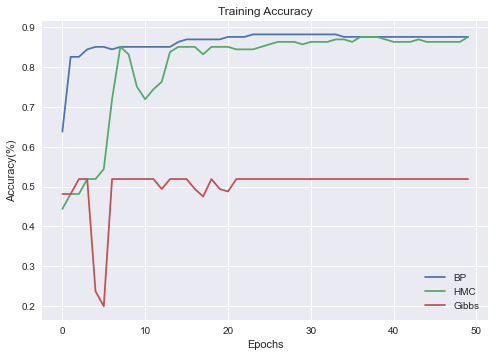

In [9]:
plt.style.use('seaborn')
plt.plot(history_bp.history['accuracy'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['train_acc'], label = 'HMC')
plt.plot(list(range(epochs)), history_gibbs['train_acc'], label = 'Gibbs')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

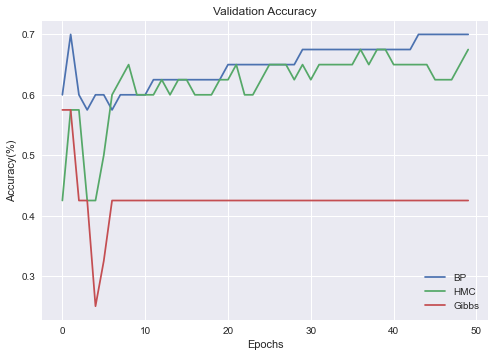

In [10]:
plt.plot(history_bp.history['val_accuracy'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['val_acc'], label = 'HMC')
plt.plot(list(range(epochs)), history_gibbs['val_acc'], label = 'Gibbs')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

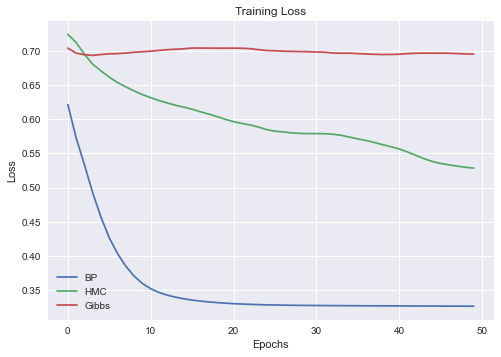

In [11]:
plt.plot(history_bp.history['loss'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['train_loss'], label = 'HMC')
plt.plot(list(range(epochs)), history_gibbs['train_loss'], label = 'Gibbs')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

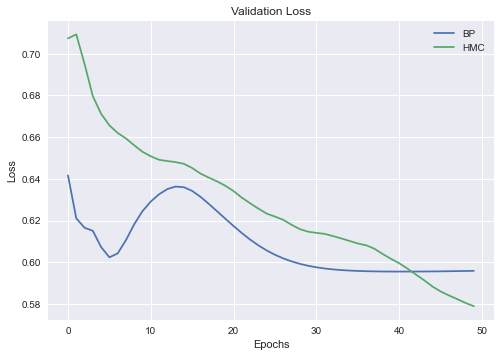

In [12]:
plt.style.use('seaborn')
plt.plot(history_bp.history['val_loss'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['val_loss'], label = 'HMC')
#plt.plot(list(range(epochs)), history_gibbs['acc'], label = 'Gibbs')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (500,) and (100,)

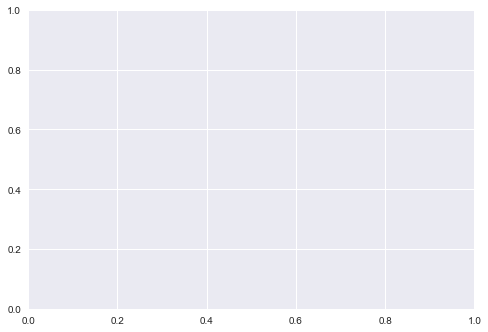

In [14]:
plt.plot(list(range(500)), burnin_loss_hmc, label = 'HMC')
plt.plot(list(range(500)), tlp_burnin_gibbs, label = 'Gibbs')
plt.title("Burnin Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()